In [ ]:
import pennylane as qml

from matplotlib import pyplot as plt

import numpy

import jax.numpy as np
import jax
import optax

import tensorflow_datasets as tfds

# np.set_printoptions(legacy="1.25")  # Fix annoying printing of numpy types

import tensorflow as tf

## Load and reduce the data

Load the MNIST data and check number of training and test examples

In [2]:
data_train, data_test = tfds.load('mnist', split=['train', 'test'], as_supervised=True)


In [3]:
# convert data_train to numpy array where first index specifies the image number
def convert_to_numpy(data):
    images = []
    labels = []
    for image, label in tfds.as_numpy(data):
        images.append(image/255.0)  # normalize to [0, 1]
        labels.append(label)
    return np.array(images), np.array(labels)

x_train, y_train = convert_to_numpy(data_train)
x_test, y_test = convert_to_numpy(data_test)

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Create a function to filter out only 0 and 1

In [4]:
def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    y = y == 0 
    y = y.astype(int)  # convert bool to int
    return x,y

In [5]:
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12665
Number of filtered test examples: 2115


Plot the original images

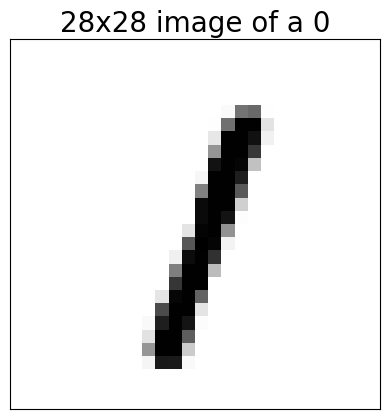

In [6]:
plt.imshow(x_train[0, :, :, 0], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title(f"28x28 image of a {y_train[0]}", fontsize=20)
# save to file as pdf
plt.savefig('28x28_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Reduce images to 9x9

In [7]:
x_train_small = tf.image.resize(x_train, (9,9)).numpy()
x_test_small = tf.image.resize(x_test, (9,9)).numpy()

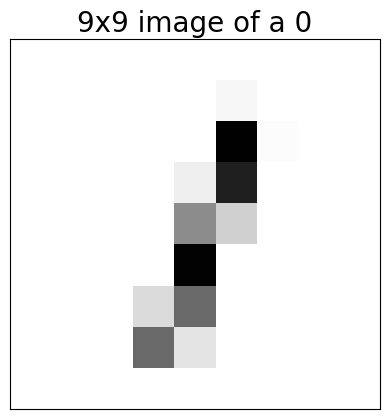

In [8]:
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title(f"9x9 image of a {y_train[0]}", fontsize=20)
# save to file as pdf
plt.savefig('9x9_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Further reduce images to 9x1

shape = (12665, 9)


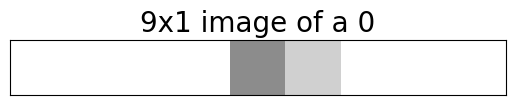

In [9]:
x_train_small = x_train_small[:,4,:,:].reshape((-1,9))  # take only central slices
x_test_small = x_test_small[:,4,:,:].reshape((-1,9))  # take only central slices
print(f"shape = {x_train_small.shape}")

plt.imshow(x_train_small[0,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title(f"9x1 image of a {y_train[0]}", fontsize=20)
# save to file as pdf
plt.savefig('9x1_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


Redefine the classification values to match the Hinge loss

In [10]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

Define the hinge accuracy

In [11]:
def hinge_accuracy(y_true, y_pred):
    y_true = y_true > 0.0
    y_pred = y_pred > 0.0
    result = y_true == y_pred
    result = result.astype(int)

    return np.mean(result).astype(float)

## Set up the Quantum Neural Network

Create quantum circuit using pennylane qnode, then conver this to a Keras layer to make a Keras model

In [12]:
n_qubits = 9
n_layers = 1

num_weights = n_layers * (2*(n_qubits-1)+1) * 3  # 3 parameters per U3 gate

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):

    if len(inputs.shape) == 1:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[ii], wires=ii)
    else:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[:,ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

@jax.jit
def hinge_loss(params, data, targets):
    predictions = qnode(data, params)
    loss = np.mean(np.maximum(0, 1 - targets * predictions))
    return loss


## Compile and train the model

Compile the model using the hinge loss and accuracy and the Adam optimiser

In [13]:
opt = optax.adam(learning_rate=0.3)

def update_step(opt, params, opt_state, data, targets):
    loss_val, grads = jax.value_and_grad(hinge_loss)(params, data, targets)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    acc_val = hinge_accuracy(targets, qnode(data, params))
    return params, opt_state, loss_val, acc_val

def optimization(params, data, targets, epochs, print_training=False):
    
    opt_state = opt.init(params)

    loss_history = []
    accuracy_history = []

    for i in range(epochs):

        params, opt_state, loss_val, acc_val = update_step(opt, params, opt_state, data, targets)

        # if i % 5 == 0:
        if print_training:
            print(f"Step: {i} Loss: {loss_val}, Accuracy: {acc_val}")

        loss_history.append(loss_val)
        accuracy_history.append(acc_val)

    return params, loss_history, accuracy_history


In [20]:
EPOCHS = 20
NUM_EXAMPLES = -1  # set to -1 for all examples, or 512 for quick test

params = 0.01*numpy.random.uniform(size=(n_layers, 2*(n_qubits-1)+1, 3))
data = x_train_small[:NUM_EXAMPLES]
targets = y_train_hinge[:NUM_EXAMPLES]

params_1, loss_history_1, accuracy_history_1 = optimization(params, data, targets, epochs=EPOCHS, print_training=True)

Step: 0 Loss: 1.0643863677978516, Accuracy: 0.4677037000656128
Step: 1 Loss: 1.0545684099197388, Accuracy: 0.8512318134307861
Step: 2 Loss: 0.8076576590538025, Accuracy: 0.43903976678848267
Step: 3 Loss: 1.0825376510620117, Accuracy: 0.7478679418563843
Step: 4 Loss: 0.8674781918525696, Accuracy: 0.8152242302894592
Step: 5 Loss: 0.6729616522789001, Accuracy: 0.8662349581718445
Step: 6 Loss: 0.5672754645347595, Accuracy: 0.9042166471481323


KeyboardInterrupt: 

# Repeat for 2 layers

In [15]:
n_qubits = 9
n_layers = 2

num_weights = n_layers * (2*(n_qubits-1)+1) * 3  # 3 parameters per U3 gate

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):

    if len(inputs.shape) == 1:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[ii], wires=ii)
    else:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[:,ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

@jax.jit
def hinge_loss(params, data, targets):
    predictions = qnode(data, params)
    loss = np.mean(np.maximum(0, 1 - targets * predictions))
    return loss


In [16]:
opt = optax.adam(learning_rate=0.3)

def update_step(opt, params, opt_state, data, targets):
    loss_val, grads = jax.value_and_grad(hinge_loss)(params, data, targets)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    acc_val = hinge_accuracy(targets, qnode(data, params))
    return params, opt_state, loss_val, acc_val

def optimization(params, data, targets, epochs, print_training=False):
    
    opt_state = opt.init(params)

    loss_history = []
    accuracy_history = []

    for i in range(epochs):

        params, opt_state, loss_val, acc_val = update_step(opt, params, opt_state, data, targets)

        # if i % 5 == 0:
        if print_training:
            print(f"Step: {i} Loss: {loss_val}, Accuracy: {acc_val}")

        loss_history.append(loss_val)
        accuracy_history.append(acc_val)

    return params, loss_history, accuracy_history


In [ ]:
EPOCHS = 20
NUM_EXAMPLES = -1  # set to -1 for all examples, or 512 for quick test

params = 0.01*numpy.random.uniform(size=(n_layers, 2*(n_qubits-1)+1, 3))
data = x_train_small[:NUM_EXAMPLES]
targets = y_train_hinge[:NUM_EXAMPLES]

params_2, loss_history_2, accuracy_history_2 = optimization(params, data, targets, epochs=EPOCHS, print_training=True)

Step: 0 Loss: 1.0582531690597534, Accuracy: 0.21875
Step: 1 Loss: 1.1390742063522339, Accuracy: 0.818359375
Step: 2 Loss: 0.9026400446891785, Accuracy: 0.794921875
Step: 3 Loss: 0.8864438533782959, Accuracy: 0.654296875
Step: 4 Loss: 0.9374447464942932, Accuracy: 0.791015625
Step: 5 Loss: 0.9321302175521851, Accuracy: 0.837890625
Step: 6 Loss: 0.8254160284996033, Accuracy: 0.900390625
Step: 7 Loss: 0.6187426447868347, Accuracy: 0.869140625
Step: 8 Loss: 0.7768644690513611, Accuracy: 0.681640625
Step: 9 Loss: 0.7953040599822998, Accuracy: 0.794921875
Step: 10 Loss: 0.8100504279136658, Accuracy: 0.859375
Step: 11 Loss: 0.5914633870124817, Accuracy: 0.861328125
Step: 12 Loss: 0.5407335162162781, Accuracy: 0.849609375
Step: 13 Loss: 0.5315637588500977, Accuracy: 0.85546875
Step: 14 Loss: 0.5243369340896606, Accuracy: 0.857421875
Step: 15 Loss: 0.4906851053237915, Accuracy: 0.859375
Step: 16 Loss: 0.48807045817375183, Accuracy: 0.8671875
Step: 17 Loss: 0.48667111992836, Accuracy: 0.87890625

## Plot the results!

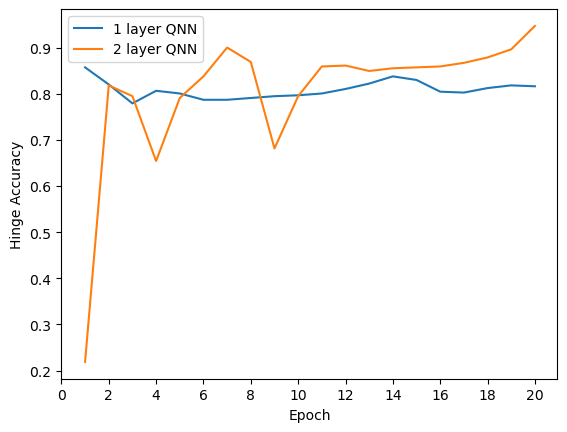

In [18]:
# plot the hinge accuracy for the qnn history for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), accuracy_history_1, label="1 layer QNN")
plt.plot(np.arange(1,21), accuracy_history_2, label="2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2))
# save as pdf with tight layout and no padding
#plt.savefig("qnn_hinge_accuracy.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

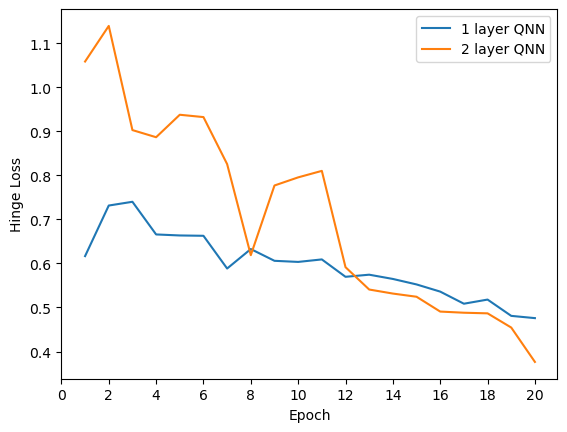

In [19]:
# plot the hinge accuracy for the loss for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), loss_history_1, label="1 layer QNN")
plt.plot(np.arange(1,21), loss_history_2, label="2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2))
# save as pdf with tight layout and no padding
#plt.savefig("qnn_hinge_loss.pdf", bbox_inches="tight", pad_inches=0)
plt.show()